## Vehicle Detection Project

The goals / steps of this project are the following:

* Perform a Histogram of Oriented Gradients (HOG) feature extraction on a labeled training set of images and train a classifier Linear SVM classifier
* Optionally, you can also apply a color transform and append binned color features, as well as histograms of color, to your HOG feature vector. 
* Note: for those first two steps don't forget to normalize your features and randomize a selection for training and testing.
* Implement a sliding-window technique and use your trained classifier to search for vehicles in images.
* Run your pipeline on a video stream (start with the test_video.mp4 and later implement on full project_video.mp4) and create a heat map of recurring detections frame by frame to reject outliers and follow detected vehicles.
* Estimate a bounding box for vehicles detected.

---

In [21]:
# Imports
import cv2
import glob
import time
import pickle
import os

import numpy as np
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from skimage.feature import hog
from sklearn.model_selection import train_test_split
from scipy.ndimage.measurements import label

#M = pickle.load( open('M.p', 'rb') )
#Minv = pickle.load( open('Minv.p', 'rb') )
#mtx = pickle.load( open('mtx.p', 'rb') )
#dist = pickle.load( open('dist.p', 'rb') )
from lanes import *

In [12]:
## Helper functions for different classes below

# Define a function to return HOG features and visualization
def get_hog_features(img, orient, pix_per_cell, cell_per_block, 
                        vis=False, feature_vec=True):
    # Call with two outputs if vis==True
    if vis == True:
        features, hog_image = hog(img, orientations=orient, 
                                  pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), 
                                  transform_sqrt=True, 
                                  visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    # Otherwise call with one output
    else:      
        features = hog(img, orientations=orient, 
                       pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), 
                       transform_sqrt=True, 
                       visualise=vis, feature_vector=feature_vec)
        return features

# Define a function to compute binned color features  
def bin_spatial(img, size=(32, 32)):
    # Use cv2.resize().ravel() to create the feature vector
    features = cv2.resize(img, size).ravel() 
    # Return the feature vector
    return features

# Spatial Bin for HOG subsample
def bin_spatial_hog_subsample(img, size=(32, 32)):
    color1 = cv2.resize(img[:,:,0], size).ravel()
    color2 = cv2.resize(img[:,:,1], size).ravel()
    color3 = cv2.resize(img[:,:,2], size).ravel()
    return np.hstack((color1, color2, color3))

# Define a function to compute color histogram features 
# NEED TO CHANGE bins_range if reading .png files with mpimg!
def color_hist(img, nbins=32, bins_range=(0, 256)):
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins, range=bins_range)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins, range=bins_range)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins, range=bins_range)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return hist_features

# Define a function to draw bounding boxes
def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    # Make a copy of the image
    imcopy = np.copy(img)
    # Iterate through the bounding boxes
    for bbox in bboxes:
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
    # Return the image copy with boxes drawn
    return imcopy

# Used fo HOG subsample approach
def convert_color(img, conv='RGB2YCrCb'):
    if conv == 'RGB2YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    if conv == 'BGR2YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_BGR2YCrCb)
    if conv == 'RGB2LUV':
        return cv2.cvtColor(img, cv2.COLOR_RGB2LUV)


In [13]:
# Define a function to extract features from a list of images
# Have this function call bin_spatial() and color_hist()
def extract_features(imgs, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for file in imgs:
        file_features = []
        # Read in each one by one
        image = mpimg.imread(file)
        # apply color conversion if other than 'RGB'
        if color_space != 'RGB':
            if color_space == 'HSV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
            elif color_space == 'LUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
            elif color_space == 'HLS':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
            elif color_space == 'YUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
            elif color_space == 'YCrCb':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
        else: feature_image = np.copy(image)      

        if spatial_feat == True:
            spatial_features = bin_spatial(feature_image, size=spatial_size)
            file_features.append(spatial_features)
        if hist_feat == True:
            # Apply color_hist()
            hist_features = color_hist(feature_image, nbins=hist_bins)
            file_features.append(hist_features)
        if hog_feat == True:
        # Call get_hog_features() with vis=False, feature_vec=True
            if hog_channel == 'ALL':
                hog_features = []
                for channel in range(feature_image.shape[2]):
                    hog_features.append(get_hog_features(feature_image[:,:,channel], 
                                        orient, pix_per_cell, cell_per_block, 
                                        vis=False, feature_vec=True))
                hog_features = np.ravel(hog_features)        
            else:
                hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                            pix_per_cell, cell_per_block, vis=False, feature_vec=True)
            # Append the new feature vector to the features list
            file_features.append(hog_features)
        features.append(np.concatenate(file_features))
    # Return list of feature vectors
    return features

In [14]:
# Define a function that takes an image,
# start and stop positions in both x and y, 
# window size (x and y dimensions),  
# and overlap fraction (for both x and y)
def slide_window(img, x_start_stop=[None, None], y_start_stop=[None, None], 
                    xy_window=(64, 64), xy_overlap=(0.5, 0.5)):
    # If x and/or y start/stop positions not defined, set to image size
    if x_start_stop[0] == None:
        x_start_stop[0] = 0
    if x_start_stop[1] == None:
        x_start_stop[1] = img.shape[1]
    if y_start_stop[0] == None:
        y_start_stop[0] = 0
    if y_start_stop[1] == None:
        y_start_stop[1] = img.shape[0]
    # Compute the span of the region to be searched    
    xspan = x_start_stop[1] - x_start_stop[0]
    yspan = y_start_stop[1] - y_start_stop[0]
    # Compute the number of pixels per step in x/y
    nx_pix_per_step = np.int(xy_window[0]*(1 - xy_overlap[0]))
    ny_pix_per_step = np.int(xy_window[1]*(1 - xy_overlap[1]))
    # Compute the number of windows in x/y
    nx_buffer = np.int(xy_window[0]*(xy_overlap[0]))
    ny_buffer = np.int(xy_window[1]*(xy_overlap[1]))
    nx_windows = np.int((xspan-nx_buffer)/nx_pix_per_step) 
    ny_windows = np.int((yspan-ny_buffer)/ny_pix_per_step) 
    # Initialize a list to append window positions to
    window_list = []
    # Loop through finding x and y window positions
    # Note: you could vectorize this step, but in practice
    # you'll be considering windows one by one with your
    # classifier, so looping makes sense
    for ys in range(ny_windows):
        for xs in range(nx_windows):
            # Calculate window position
            startx = xs*nx_pix_per_step + x_start_stop[0]
            endx = startx + xy_window[0]
            starty = ys*ny_pix_per_step + y_start_stop[0]
            endy = starty + xy_window[1]
            
            # Append window position to list
            window_list.append(((startx, starty), (endx, endy)))
    # Return the list of windows
    return window_list

Test Accuracy of SVC =  0.9702


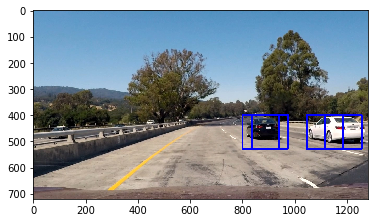

In [272]:
class SearchAndClassify(object):
    
    def __init__(self):
        self.color_space = 'RGB' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
        self.orient = 9  # HOG orientations
        self.pix_per_cell = 8 # HOG pixels per cell
        self.cell_per_block = 2 # HOG cells per block
        self.hog_channel = 2 # Can be 0, 1, 2, or "ALL"
        self.spatial_size = (16, 16) # Spatial binning dimensions
        self.hist_bins = 32    # Number of histogram bins
        self.spatial_feat = True # Spatial features on or off
        self.hist_feat = True # Histogram features on or off
        self.hog_feat = True # HOG features on or off
        self.y_start_stop = [None, None] # Min and max in y to search in slide_window()
        self.cars = []
        self.notcars = []
        
    def single_img_features(self, img, color_space='RGB', spatial_size=(32, 32),
                            hist_bins=32, orient=9, 
                            pix_per_cell=8, cell_per_block=2, hog_channel=0,
                            spatial_feat=True, hist_feat=True, hog_feat=True):   
        #1) Define an empty list to receive features
        img_features = []
        #2) Apply color conversion if other than 'RGB'
        if color_space != 'RGB':
            if color_space == 'HSV':
                feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
            elif color_space == 'LUV':
                feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
            elif color_space == 'HLS':
                feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
            elif color_space == 'YUV':
                feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
            elif color_space == 'YCrCb':
                feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
        else: 
            feature_image = np.copy(img)      
        #3) Compute spatial features if flag is set
        if spatial_feat == True:
            spatial_features = bin_spatial(feature_image, size=spatial_size)
            #4) Append features to list
            img_features.append(spatial_features)
        #5) Compute histogram features if flag is set
        if hist_feat == True:
            hist_features = color_hist(feature_image, nbins=hist_bins)
            #6) Append features to list
            img_features.append(hist_features)
        #7) Compute HOG features if flag is set
        if hog_feat == True:
            if hog_channel == 'ALL':
                hog_features = []
                for channel in range(feature_image.shape[2]):
                    hog_features.extend(get_hog_features(feature_image[:,:,channel], 
                                        orient, pix_per_cell, cell_per_block, 
                                        vis=False, feature_vec=True))      
            else:
                hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                            pix_per_cell, cell_per_block, vis=False, feature_vec=True)
            #8) Append features to list
            img_features.append(hog_features)

        #9) Return concatenated array of features
        return np.concatenate(img_features)
        
    # Define a function you will pass an image 
    # and the list of windows to be searched (output of slide_windows())
    def search_windows(self, img, windows, clf, scaler, color_space='RGB', 
                        spatial_size=(32, 32), hist_bins=32, 
                        hist_range=(0, 256), orient=9, 
                        pix_per_cell=8, cell_per_block=2, 
                        hog_channel=0, spatial_feat=True, 
                        hist_feat=True, hog_feat=True):
        #1) Create an empty list to receive positive detection windows
        on_windows = []
        #2) Iterate over all windows in the list
        for window in windows:
            #3) Extract the test window from original image
            test_img = cv2.resize(img[window[0][1]:window[1][1], 
                                      window[0][0]:window[1][0]], 
                                      (64, 64))      
            #4) Extract features for that window using single_img_features()
            features = self.single_img_features(test_img, color_space=color_space, 
                                spatial_size=spatial_size, hist_bins=hist_bins, 
                                orient=orient, pix_per_cell=pix_per_cell, 
                                cell_per_block=cell_per_block, 
                                hog_channel=hog_channel, spatial_feat=spatial_feat, 
                                hist_feat=hist_feat, hog_feat=hog_feat)
            #5) Scale extracted features to be fed to classifier
            test_features = scaler.transform(np.array(features).reshape(1, -1))
            #6) Predict using your classifier
            prediction = clf.predict(test_features)
            #7) If positive (prediction == 1) then save the window
            if prediction == 1:
                on_windows.append(window)
        #8) Return windows for positive detections
        return on_windows
    
    def read_data(self):
        # Read in cars and notcars
        for base, _, images in os.walk('data'):
            for image in images:
                if image.endswith('.jpg') or image.endswith('.png') or image.endswith('.jpeg'):
                    path = os.path.join(base, image)
                    if 'non-vehicles' in path:
                        self.notcars.append(path)
                    else:
                        self.cars.append(path)
        print('read images: cars ', len(self.cars), ' not-cars', len(self.notcars))
    
    def preprocessing(self):
        print('Extracting cars features')
        car_features = extract_features(self.cars, color_space=self.color_space, 
                            spatial_size=self.spatial_size, hist_bins=self.hist_bins, 
                            orient=self.orient, pix_per_cell=self.pix_per_cell, 
                            cell_per_block=self.cell_per_block, 
                            hog_channel=self.hog_channel, spatial_feat=self.spatial_feat, 
                            hist_feat=self.hist_feat, hog_feat=self.hog_feat)
        print('... Done.')
        #Check that features were extracted successfully
        assert car_features is not None
        
        print('Extracting non cars features')
        notcar_features = extract_features(self.notcars, color_space=self.color_space, 
                            spatial_size=self.spatial_size, hist_bins=self.hist_bins, 
                            orient=self.orient, pix_per_cell=self.pix_per_cell, 
                            cell_per_block=self.cell_per_block, 
                            hog_channel=self.hog_channel, spatial_feat=self.spatial_feat, 
                            hist_feat=self.hist_feat, hog_feat=self.hog_feat)
        print('... Done.')
        #Check that features were extracted successfully
        assert notcar_features is not None
        
        X = np.vstack((car_features, notcar_features)).astype(np.float64)                        
        # Fit a per-column scaler
        self.X_scaler = StandardScaler().fit(X)
        # Apply the scaler to X
        scaled_X = self.X_scaler.transform(X)
        # Define the labels vector
        y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))

        # Split up data into randomized training and test sets
        rand_state = np.random.randint(0, 100)
        X_train, X_test, y_train, y_test = train_test_split(
                                scaled_X, y, test_size=0.2, random_state=rand_state)
        print('Using:',self.orient,'orientations', self.pix_per_cell, 'pixels per cell and', 
              self.cell_per_block,'cells per block')
        print('Feature vector length:', len(X_train[0]))
        return (X_train, y_train, X_test, y_test, self.X_scaler)
    
    def train_classifier(self, X_train=None, y_train=None, load_from_disk=False):
        # Use a linear SVC 
        svc = LinearSVC()
        # Check the training time for the SVC
        t=time.time()
        # load train sets
        if load_from_disk:
            with open('X_train.p', 'rb') as dataset:
                X_train = pickle.load(dataset)
            with open('y_train.p', 'rb') as dataset:
                y_train = pickle.load(dataset)
        assert X_train is not None
        assert y_train is not None
        # fit the classifier
        svc.fit(X_train, y_train)
        t2 = time.time()
        print(round(t2-t, 2), 'Seconds to train SVC...')
        #Save classifier for later use
        with open('cars_svc.p', 'wb') as classifier:
            pickle.dump(svc, classifier)
        print('... Saved classifier to disk.')
        
    def train(self):
        self.read_data()
        # Extract features, normalize and prepare test, train datasets
        X_train, y_train, X_test, y_test, X_scaler = self.preprocessing()
        # write features to disk
        with open('X_train.p', 'wb') as dataset:
            pickle.dump(X_train, dataset)
        with open('X_test.p', 'wb') as dataset:
            pickle.dump(X_test, dataset)
        with open('y_train.p', 'wb') as dataset:
            pickle.dump(y_train, dataset)
        with open('y_test.p', 'wb') as dataset:
            pickle.dump(y_test, dataset)
        with open('X_scaler.p', 'wb') as dataset:
            pickle.dump(X_scaler, dataset)
        print('Wrote features to disk.')
        # Train the classifier 
        sc.train_classifier(X_train=X_train, y_train=y_train)
    
    def add_bbox_img(self, image, svc, X_scaler):
        draw_image = np.copy(image) 
        # Uncomment the following line if you extracted training
        # data from .png images (scaled 0 to 1 by mpimg) and the
        # image you are searching is a .jpg (scaled 0 to 255)
        image = image.astype(np.float32)/255
        
        # get the road portion of image for sliding window search
        rimage = image[400:600, 450:]

        windows = slide_window(rimage, x_start_stop=[None, None], 
                            y_start_stop=self.y_start_stop, 
                            xy_window=(140, 128), xy_overlap=(0.75, 0.25))

        hot_windows = self.search_windows(rimage, windows, svc, X_scaler, 
                                          color_space=self.color_space, 
                                          spatial_size=self.spatial_size, 
                                          hist_bins=self.hist_bins, 
                                          orient=self.orient, 
                                          pix_per_cell=self.pix_per_cell, 
                                          cell_per_block=self.cell_per_block, 
                                          hog_channel=self.hog_channel, 
                                          spatial_feat=self.spatial_feat, 
                                          hist_feat=self.hist_feat, 
                                          hog_feat=self.hog_feat)
        hot_windows = [((bbox[0][0]+450, bbox[0][1]+400), (bbox[1][0]+450, bbox[1][1]+400) ) for bbox in hot_windows]
        return hot_windows
        
    def test_classifier(self):
        # load test sets
        with open('X_test.p', 'rb') as dataset:
           X_test = pickle.load(dataset)
        assert X_test is not None
        with open('y_test.p', 'rb') as dataset:
            y_test = pickle.load(dataset)
        assert y_test is not None
        with open('X_scaler.p', 'rb') as dataset:
              X_scaler = pickle.load(dataset)
        assert X_scaler is not None
        
        # load classifier
        svc = None
        with open('cars_svc.p', 'rb') as classifier:
          svc = pickle.load(classifier)
        assert svc is not None
           
        # Check the score of the SVC
        print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))
        # Check the prediction time for a single sample
        t=time.time()
        image = mpimg.imread('test_images/test1.jpg')
        draw_image = np.copy(image)
        
        # Uncomment the following line if you extracted training
        # data from .png images (scaled 0 to 1 by mpimg) and the
        # image you are searching is a .jpg (scaled 0 to 255)
        image = image.astype(np.float32)/255
        
        # get the road portion of image for sliding window search
        rimage = image[400:600, 450:]
        windows = slide_window(rimage, x_start_stop=[None, None], 
                            y_start_stop=self.y_start_stop, 
                            xy_window=(140, 128), xy_overlap=(0.75, 0.25))
        #windows += slide_window(rimage, x_start_stop=[None, None], 
        #                    y_start_stop=self.y_start_stop, 
        #                    xy_window=(96, 96), xy_overlap=(0.5, 0.5))

        hot_windows = self.search_windows(rimage, windows, svc, X_scaler, 
                                          color_space=self.color_space, 
                                          spatial_size=self.spatial_size, 
                                          hist_bins=self.hist_bins, 
                                          orient=self.orient, 
                                          pix_per_cell=self.pix_per_cell, 
                                          cell_per_block=self.cell_per_block, 
                                          hog_channel=self.hog_channel, 
                                          spatial_feat=self.spatial_feat, 
                                          hist_feat=self.hist_feat, 
                                          hog_feat=self.hog_feat)
        #fix bbox y position
        hot_windows = [((bbox[0][0]+450, bbox[0][1]+400), (bbox[1][0]+450, bbox[1][1]+400) ) for bbox in hot_windows]
        window_img = draw_boxes(draw_image, hot_windows, color=(0, 0, 255), thick=6)
        # Save bboxes for heat maps
        with open('test_bboxes.p', 'wb') as bboxes:
            pickle.dump(hot_windows, bboxes)
        plt.imshow(window_img)
    
#Train Classifier and test on an image
sc = SearchAndClassify()
#sc.train()
sc.test_classifier()


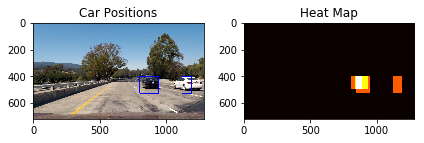

In [261]:
class HeatMapLabel(object):
    
    def __init__(self):
           pass

    def add_heat(self, heatmap, bbox_list):
        # Iterate through list of bboxes
        for box in bbox_list:
            # Add += 1 for all pixels inside each bbox
            # Assuming each "box" takes the form ((x1, y1), (x2, y2))
            heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1
        # Return updated heatmap
        return heatmap# Iterate through list of bboxes
    
    def apply_threshold(self, heatmap, threshold):
        # Zero out pixels below the threshold
        heatmap[heatmap <= threshold] = 0
        # Return thresholded map
        return heatmap

    def draw_labeled_bboxes(self, img, labels):
        # Iterate through all detected cars
        for car_number in range(1, labels[1]+1):
            # Find pixels with each car_number label value
            nonzero = (labels[0] == car_number).nonzero()
            # Identify x and y values of those pixels
            nonzeroy = np.array(nonzero[0])
            nonzerox = np.array(nonzero[1])
            # Define a bounding box based on min/max x and y
            bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
            # Draw the box on the image
            cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
        # Return the image
        return img

    def create_heatmap(self, image, box_list):
        heat = np.zeros_like(image[:,:,0]).astype(np.float)
        # Add heat to each box in box list
        heat = self.add_heat(heat, box_list)
        # Apply threshold to help remove false positives
        heat = self.apply_threshold(heat, 1)
        # Visualize the heatmap when displaying    
        heatmap = np.clip(heat, 0, 255)
        # Find final boxes from heatmap using label function
        labels = label(heatmap)
        draw_img = self.draw_labeled_bboxes(np.copy(image), labels)
        return (draw_img, heatmap)

    def plot_sample(self, draw_image, heatmap):
        fig = plt.figure()
        plt.subplot(121)
        plt.imshow(draw_img)
        plt.title('Car Positions')
        plt.subplot(122)
        plt.imshow(heatmap, cmap='hot')
        plt.title('Heat Map')
        fig.tight_layout()
        
hm_label = HeatMapLabel()
box_list = pickle.load( open( "test_bboxes.p", "rb" ))
hm_image = mpimg.imread('test_images/test1.jpg')
draw_img, heatmap = hm_label.create_heatmap(hm_image, box_list)
hm_label.plot_sample(draw_img, heatmap)

In [273]:
# Test on sample images
def test_images():
    # load test sets
    with open('X_scaler.p', 'rb') as dataset:
        X_scaler = pickle.load(dataset)
    assert X_scaler is not None
    # load classifier
    svc = None
    with open('cars_svc.p', 'rb') as classifier:
        svc = pickle.load(classifier)
    assert svc is not None
    # initialize pipeline classes
    sc = SearchAndClassify()
    hm_label = HeatMapLabel()
    ln = Line(Minv)
    # add bbox for cars while iterating over images 
    for base, _, test_images in os.walk('test_images'):
        for image_file in test_images:
            print('Processing image ', image_file)
            image_path = os.path.join(base, image_file)
            output_path = os.path.join('output_images', image_file)
            test_image = mpimg.imread(image_path)
            box_list = sc.add_bbox_img(test_image, svc, X_scaler)
            #lanes = ln.process_image(test_image)
            vehicles_w_lanes, _ = hm_label.create_heatmap(test_image, box_list)
            #output = np.concatenate((lanes, vehicles), axis=1)
            plt.imsave(output_path, vehicles_w_lanes)
test_images()

Processing image  test5.jpg
Processing image  test1.jpg
Processing image  test6.jpg
Processing image  test2.jpg
Processing image  test4.jpg
Processing image  test3.jpg


In [80]:
# processing pipeline for an image
class VehicleDetection(object):
    
    def __init__(self):
        self.X_scaler = pickle.load(open('X_scaler.p', 'rb'))
        self.svc = pickle.load(open('cars_svc.p', 'rb'))
        self.sc = SearchAndClassify()
        self.hm_label = HeatMapLabel()
        self.last_boxes = []
        assert self.X_scaler is not None
        assert self.svc is not None
        # lane mapping reqs
        self.ln = Line(Minv)
            
    def process_image(self, image):
        box_list = self.sc.add_bbox_img(image, self.svc, self.X_scaler)
        lanes = self.ln.process_image(image)
        vehicles_w_lanes, _ = self.hm_label.create_heatmap(lanes, box_list)
        #output = np.concatenate(lanes, vehicles)
        return vehicles_w_lanes

In [262]:
# Test pipleline on smaller test video
from moviepy.editor import VideoFileClip
from IPython.display import HTML

lanes_output = 'result_test_video.mp4'
vd = VehicleDetection()
clip1 = VideoFileClip("test_video.mp4")
result_clip = clip1.fl_image(vd.process_image)
result_clip.write_videofile(lanes_output, audio=False)

[MoviePy] >>>> Building video result_test_video.mp4
[MoviePy] Writing video result_test_video.mp4



 97%|█████████▋| 38/39 [00:21<00:00,  1.75it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: result_test_video.mp4 



In [263]:
from moviepy.editor import VideoFileClip
from IPython.display import HTML

lanes_output = 'result_video.mp4'
vd = VehicleDetection()
clip1 = VideoFileClip("project_video.mp4")
result_clip = clip1.fl_image(vd.process_image)
result_clip.write_videofile(lanes_output, audio=False)

[MoviePy] >>>> Building video result_video.mp4
[MoviePy] Writing video result_video.mp4



100%|█████████▉| 1260/1261 [11:53<00:00,  1.77it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: result_video.mp4 



In [ ]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(lanes_output))